### EDA

#### Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pypair.association import binary_binary, continuous_continuous, binary_continuous

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

#### Preparing Data

##### Reading and filtering

In [ ]:
bd_all = pd.read_spss('17_abril.sav')

# Filter the dataset to work only with alcohol patients
bd = bd_all[bd_all['Alcohol_DxCIE'] == 'Sí']

# Filter the dataset to work only with 'Situacion_tratamiento' == 'Abandono' or 'Alta'
bd = bd[(bd['Situacion_tratamiento'] == 'Abandono') | (bd['Situacion_tratamiento'] == 'Alta terapéutica')]

##### Defining sets of patients

In [ ]:
# Pre-pandemic
conj_pre = bd[bd['Pandemia_inicio_fin_tratamiento'] == 'Inicio y fin prepandemia']
# Pre-pandemic abandono
pre_abandono = conj_pre[conj_pre['Situacion_tratamiento'] == 'Abandono']
# Pre-pandemic alta
pre_alta = conj_pre[conj_pre['Situacion_tratamiento'] == 'Alta terapéutica']

# Post-pandemic
# Merging last two classes to balance sets
conj_post = bd[(bd['Pandemia_inicio_fin_tratamiento'] == 'Inicio prepandemia y fin en pandemia') | 
               (bd['Pandemia_inicio_fin_tratamiento'] == 'inicio y fin en pandemia')]
# Post-pandemic abandono
post_abandono = conj_post[conj_post['Situacion_tratamiento'] == 'Abandono']
# Post-pandemic alta
post_alta = conj_post[conj_post['Situacion_tratamiento'] == 'Alta terapéutica']

# Concatenate the two data frames and add a new column to distinguish between them. Useful for plots
conj_post['Group'] = 'Post'
conj_pre['Group'] = 'Pre'
combined_pre_post = pd.concat([conj_post, conj_pre])

#### First Steps

##### Inspecting the dataframes

In [ ]:
print("PRE")
print(conj_pre.info())
print ("-------------------------------")
print("PRE-ABANDONO")
print(pre_abandono.info())
print ("-------------------------------")
print("PRE-ALTA")
print(pre_alta.info())
print ("-------------------------------")

print("\n\n\n")

print ("POST")
print(conj_post.info())
print ("-------------------------------")
print("POST-ABANDONO")
print(post_abandono.info())
print ("-------------------------------")
print("POST-ALTA")
print(post_alta.info())
print ("-------------------------------")

##### Replacing unknown values with the mode

In [ ]:
# 9.0 represents unknown according to Variables.docx 
print(bd['Social_inclusion'].unique())
mode_soc_inc = bd['Social_inclusion'].mode()[0]
# print(mode_soc_inc)
bd['Social_inclusion'] = bd['Social_inclusion'].replace('9.0', mode_soc_inc)
print(bd['Social_inclusion'].unique())

In [ ]:
print(bd['Alterations_early_childhood_develop'].unique())
mode_alt = bd['Alterations_early_childhood_develop'].mode()[0]
bd['Alterations_early_childhood_develop'] = bd['Alterations_early_childhood_develop'].replace('9', mode_alt)
print(bd['Alterations_early_childhood_develop'].unique())

In [ ]:
print(bd['Risk_stigma'].unique())
mode_stigma = bd['Risk_stigma'].mode()[0]
bd['Risk_stigma'] = bd['Risk_stigma'].replace(99.0, mode_stigma)
print(bd['Risk_stigma'].unique())

In [ ]:
print(bd['NumHijos'].unique())
mode_hijos = bd['NumHijos'].mode()[0]
bd['NumHijos'] = bd['NumHijos'].replace(99.0, mode_hijos)
print(bd['NumHijos'].unique())

##### Quantifying Null Values

In [ ]:
print(f"Total missing values Age: {bd['Age'].isnull().sum()}")
print(f"Total missing values Años_consumo_droga: {bd['Años_consumo_droga'].isnull().sum()}")
print(f"Total missing values Risk_stigma: {bd['Risk_stigma'].isnull().sum()}")
print(f"Total missing values NumHijos: {bd['NumHijos'].isnull().sum()}")

print("\tCONJUNTO PREPANDEMIA")
print(f"\t\tMissing values Age: {conj_pre['Age'].isnull().sum()}")
print(f"\t\tMissing values Años_consumo_droga: {conj_pre['Años_consumo_droga'].isnull().sum()}")
print(f"\t\tMissing values Risk_stigma: {conj_pre['Risk_stigma'].isnull().sum()}")
print(f"\t\tMissing values NumHijos: {conj_pre['NumHijos'].isnull().sum()}")

print("\tCONJUNTO POSTPANDEMIA")
print(f"\t\tMissing values Age: {conj_post['Age'].isnull().sum()}")
print(f"\t\tMissing values Años_consumo_droga: {conj_post['Años_consumo_droga'].isnull().sum()}")
print(f"\t\tMissing values Risk_stigma: {conj_post['Risk_stigma'].isnull().sum()}")
print(f"\t\tMissing values NumHijos: {conj_post['NumHijos'].isnull().sum()}")

##### Replacing missing values with mode

In [ ]:
age_mode = bd['Age'].mode()[0]
bd['Age'].fillna(age_mode, inplace=True)

años_consumo_mode = bd['Años_consumo_droga'].mode()[0]
bd['Años_consumo_droga'].fillna(años_consumo_mode, inplace=True)

risk_stigma_mode = bd['Risk_stigma'].mode()[0]
bd['Risk_stigma'].fillna(risk_stigma_mode, inplace=True)

num_hijos_mode = bd['NumHijos'].mode()[0]
bd['NumHijos'].fillna(num_hijos_mode, inplace=True)

#### Distribution of variables

##### Classifying variables into numerical and discrete/categorical 

In [ ]:
disc_atts = ['Education', 'Social_protection', 'Job_insecurity', 'Housing',
        'Alterations_early_childhood_develop', 'Social_inclusion',
        'Risk_stigma', 'Sex', 'NumHijos', 'Smoking', 'Biological_vulnerability',
        'Opiaceos_DxCIE', 'Cannabis_DXCIE', 'BZD_DxCIE', 'Cocaina_DxCIE',
        'Alucinogenos_DXCIE', 'Tabaco_DXCIE', 'FrecuenciaConsumo30Dias',
        'OtrosDx_Psiquiatrico', 'Tx_previos', 'Readmisiones_estudios', 'Nreadmision'
        ]

num_atts = ['Structural_conflic', 'Adherencia_tto_recalc', 'Age', 'Años_consumo_droga', 'Tiempo_tx']

##### Distribution of discrete attributes

###### Count plots

In [ ]:
fig, axs = plt.subplots(len(disc_atts), 1, figsize=(15, 5*len(disc_atts)))
plt.subplots_adjust(hspace=0.75, wspace=1.25)

for i, disc_att in enumerate(disc_atts):
    ax = sns.countplot(x=disc_att, data=combined_pre_post, hue=combined_pre_post[['Situacion_tratamiento', 'Group']].apply(tuple, axis=1),
                       hue_order=[('Abandono', 'Pre'),('Alta terapéutica', 'Pre'), ('Abandono', 'Post'), ('Alta terapéutica', 'Post')],
                       ax=axs[i])
    ax.set_title(disc_att, fontsize=16, fontweight='bold')
    ax.get_legend().set_title("Groups")
    
    # Adding count annotations
    for p in ax.patches:
        if p.get_label() == '_nolegend_':
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Save the figure in SVG format with DPI=600 in the "./EDA_plots" folder
plt.savefig('./EDA_plots/countplots.svg', dpi=600, bbox_inches='tight')

###### Normalized count plots

In [ ]:
# Function to plot countplot 
def plot_count_perc_norm(i: int, group:int, disc_att:str) -> None:
    """
        group: 1 (all), 2 (pre), 3 (post) 
    """

    # Define data to work with based on group
    if group == 1:
        df = bd 
    elif group == 2:
        df = conj_pre
    elif group == 3:
        df = conj_post

    # GOAL: find percentage of each possible category within the total of its situacion_tto subset
    # Group data by 'Situacion_tratamiento' and 'Education' and count occurrences
    grouped_counts = df.groupby(['Situacion_tratamiento', disc_att]).size().reset_index(name='count')
    # Calculate total count for each 'Situacion_tratamiento' group
    total_counts = df.groupby('Situacion_tratamiento')[disc_att].count()
    # Divide each count by its corresponding total count and calculate percentage
    grouped_counts['percentage'] = grouped_counts.apply(lambda row: row['count'] / total_counts[row['Situacion_tratamiento']] * 100, axis=1)
    
    # Follow the same order in plot as in computations
    col_order = grouped_counts[grouped_counts['Situacion_tratamiento'] == 'Abandono'][disc_att].tolist()

    # Create countplot and split each bar into two based on the value of sit_tto
    ax = sns.countplot(x=disc_att, hue='Situacion_tratamiento', data=df, order=col_order, ax=axs[i, group-2])

    # Adjust y-axis to represent percentages out of the total count
    ax.set_ylim(0, 100)

    percentages = grouped_counts['percentage']
    for i, p in enumerate(ax.patches):
        # Skip going over the legend values
        if p.get_label() == "_nolegend_":
            # Set height to corresponding percentage and annotate result
            height = percentages[i]
            p.set_height(height)
            ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=6, color='black', xytext=(0, 5),
                        textcoords='offset points')

In [ ]:
fig, axs = plt.subplots(len(disc_atts), 2, figsize=(15, 7*len(disc_atts)))
plt.subplots_adjust(hspace=0.75, wspace=1.5)

for i, disc_att in enumerate(disc_atts):

    # # 1: ALL    
    # plot_count_perc_norm(i, 1, disc_att)
    # axs[i, 0].set_title("\nALL")
    # axs[i, 0].set_xlabel(disc_att, fontweight='bold')
    # axs[i, 0].set_ylabel("% of total within its Sit_tto group")
    # axs[i, 0].tick_params(axis='x', rotation=90)
    
    # 2: PRE
    plot_count_perc_norm(i, 2, disc_att)
    axs[i, 0].set_title("\nPRE")
    axs[i, 0].set_xlabel(disc_att, fontweight='bold')
    axs[i, 0].set_ylabel("% of total within its Sit_tto group")
    axs[i, 0].tick_params(axis='x', rotation=90)

    # 3: POST
    plot_count_perc_norm(i, 3, disc_att)
    axs[i, 1].set_title("\nPOST")
    axs[i, 1].set_xlabel(disc_att, fontweight='bold')
    axs[i, 1].set_ylabel("% of total within its Sit_tto group")
    axs[i, 1].tick_params(axis='x', rotation=90)

    
# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Save the figure in SVG format with DPI=600 in the "./EDA_plots" folder
plt.savefig('./EDA_plots/norm_countplots.svg', dpi=600, bbox_inches='tight')

##### Distribution of numeric attributes

###### Summary statistics

In [ ]:
print(bd[num_atts].describe())

###### Boxplots

In [ ]:
fig, axs = plt.subplots(len(num_atts), 1, figsize=(12, 5*len(num_atts)))
plt.subplots_adjust(hspace=0.75, wspace=1.5)

for i, num_att in enumerate(num_atts):
    plt.subplot(len(num_atts), 1, i+1)
    sns.boxplot(
        data=combined_pre_post,
        x = num_att,
        y = 'Group',
        hue='Situacion_tratamiento',
    )

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Save the figure in SVG format with DPI=600 in the "./EDA_plots" folder
plt.savefig('./EDA_plots/boxplots.svg', dpi=600, bbox_inches='tight')

###### Histograms

In [ ]:
fig, axs = plt.subplots(len(num_atts), 3, figsize=(15, 6*len(num_atts)))
plt.subplots_adjust(hspace=0.75, wspace=1.5)

for i, num_att in enumerate(num_atts):

    # 1: All alcohol patients
    sns.histplot(data=bd,x=num_att,bins=15, hue='Situacion_tratamiento', stat='probability', common_norm=False, kde=True,
                 line_kws={'lw': 5}, alpha = 0.4, ax=axs[i, 0])
    axs[i, 0].set_title(f"\nDistr. of {num_att}  - ALL")

    # 2: PRE
    sns.histplot(data=conj_pre,x=num_att,bins=15, hue='Situacion_tratamiento', stat='probability', common_norm=False, kde=True, 
                 line_kws={'lw': 5}, alpha = 0.4, ax=axs[i, 1])
    axs[i, 1].set_title(f"\nDistr. of {num_att}  - PRE")

    # Subplot 3: POST
    sns.histplot(data=conj_post,x=num_att,bins=15, hue='Situacion_tratamiento', stat='probability', common_norm=False, kde=True, 
                 line_kws={'lw': 5}, alpha = 0.4, ax=axs[i, 2])
    axs[i, 2].set_title(f"\nDistr. of {num_att}  - POST")

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Save the figure in SVG format with DPI=600 in the "./EDA_plots" folder
plt.savefig('./EDA_plots/histograms.svg', dpi=600, bbox_inches='tight')

#### Correlation Analysis

##### Turning binary variables into 0/1 values

In [ ]:
# --------------------------------------------------------------------------

# 'Alterations_early_childhood_develop'
alterations_mapping = {
    'No alterations (first exposure at 11 or more years)' : 0,
    'Alterations (first exposure before 11 years old)': 1,
}

bd['Alterations_early_childhood_develop_REDEF'] = bd['Alterations_early_childhood_develop'].map(alterations_mapping)

# --------------------------------------------------------------------------

# Social protection
bd['Social_protection_REDEF'] = bd['Social_protection'].map({'No':0, 'Sí':1})

# --------------------------------------------------------------------------

# 'Risk_stigma'
bd['Risk_stigma_REDEF'] = bd['Risk_stigma'].map({'No':0, 'Yes':1})

# --------------------------------------------------------------------------

# 'Sex'
bd['Sex_REDEF'] = bd['Sex'].map({'Hombre':0, 'Mujer':1})

# --------------------------------------------------------------------------

# 'Smoking'
bd['Smoking_REDEF'] = bd['Smoking'].map({'No':0, 'Sí':1})

# --------------------------------------------------------------------------

# 'Biological_vulnerability'
bd['Biological_vulnerability_REDEF'] = bd['Biological_vulnerability'].map({'No':0, 'Sí':1})

# --------------------------------------------------------------------------

# 'Droga_DxCIE'
bd['Opiaceos_DxCIE_REDEF'] = bd['Opiaceos_DxCIE'].map({'No': 0, 'Sí': 1})
bd['Cannabis_DXCIE_REDEF'] = bd['Cannabis_DXCIE'].map({'No': 0, 'Sí': 1})
bd['BZD_DxCIE_REDEF'] = bd['BZD_DxCIE'].map({'No': 0, 'Sí': 1})
bd['Cocaina_DxCIE_REDEF'] = bd['Cocaina_DxCIE'].map({'No': 0, 'Sí': 1})
bd['Alucinogenos_DXCIE_REDEF'] = bd['Alucinogenos_DXCIE'].map({'No': 0, 'Sí': 1})
bd['Tabaco_DXCIE_REDEF'] = bd['Tabaco_DXCIE'].map({'No': 0, 'Sí': 1})

# --------------------------------------------------------------------------

# 'OtrosDx_Psiquiatrico'
bd['OtrosDx_Psiquiatrico_REDEF'] = bd['OtrosDx_Psiquiatrico'].map({'No':0, 'Sí':1})

# --------------------------------------------------------------------------

# 'Tx_previos'
bd['Tx_previos_REDEF'] = bd['Tx_previos'].map({'No':0, 'Sí':1})

# --------------------------------------------------------------------------

# 'Situacion_tratamiento'
bd['Situacion_tratamiento_REDEF'] = bd['Situacion_tratamiento'].map({'Abandono':0, 'Alta terapéutica':1})

# --------------------------------------------------------------------------

##### Defining groups of variables

In [ ]:
social_vars = ['Education', 'Social_protection', 'Job_insecurity', 'Housing', 'Alterations_early_childhood_develop', 
            'Social_inclusion', 'Risk_stigma', 'Structural_conflic']
ind_vars = ['Age', 'Sex', 'NumHijos', 'Smoking', 'Biological_vulnerability', 'Opiaceos_DxCIE', 
            'Cannabis_DXCIE', 'BZD_DxCIE', 'Cocaina_DxCIE', 'Alucinogenos_DXCIE', 'Tabaco_DXCIE', 
            'FrecuenciaConsumo30Dias', 'Años_consumo_droga','OtrosDx_Psiquiatrico', 'Tx_previos', 'Adherencia_tto_recalc'] 
target_var = 'Situacion_tratamiento'

# Incluir alcohol?

In [ ]:
# Columns that are already numeric and we don't need to redefine 
no_redef_cols = ['Structural_conflic', 'Age', 'NumHijos', 'Años_consumo_droga', 'Adherencia_tto_recalc']

In [ ]:
# res_vars = ['Tiempo_tx', 'Readmisiones_estudios', 'Periodos_COVID', 'Pandemia_inicio_fin_tratamiento', 
#            'Nreadmision', 'Readmisiones_PRECOVID', 'Readmisiones_COVID']

##### One-hot encode categorical variables

In [ ]:
# Specify columns to one hot encode; empty list otherwise
one_hot_vars = ['Education', 'Job_insecurity', 'Housing', 'Social_inclusion', 'FrecuenciaConsumo30Dias']

one_hots_vars_prefix = {
    'Education': 'Ed',
    'Job_insecurity': 'JobIn',
    'Housing': 'Hous', 
    'Social_inclusion': 'SocInc',
    'FrecuenciaConsumo30Dias': 'Frec30',
}

one_hot_cols_dic = {}

for one_hot_var in one_hot_vars:
    # Create one hot encoding version of attribute and concatenate new columns to main df
    encoded_var = pd.get_dummies(bd[one_hot_var], prefix=one_hots_vars_prefix[one_hot_var])
    bd = pd.concat([bd, encoded_var], axis=1)
    one_hot_cols_dic[one_hot_var] = encoded_var.columns.tolist()

# print(one_hot_cols_dic['FrecuenciaConsumo30Dias'])

###### Defining final version of columns of interest

In [ ]:
soc_vars_enc = []
for soc_var in social_vars:
    # If no need to redefine, append directly
    if soc_var in no_redef_cols:
        soc_vars_enc.append(soc_var)
    # If need to redefine
    else:
        # Check if it was one-hot encoded
        if soc_var in one_hot_vars:
            # Append all one hot columns
            soc_vars_enc = soc_vars_enc + one_hot_cols_dic[soc_var]
        # If not, use redefined version through mapping
        else:
            soc_vars_enc.append(soc_var + '_REDEF')

ind_vars_enc = []
for ind_var in ind_vars:
    # If no need to redefine, append directly
    if ind_var in no_redef_cols:
        ind_vars_enc.append(ind_var)
    # If need to redefine
    else:
        # Check if it was one-hot encoded
        if ind_var in one_hot_vars:
            # Append all one hot columns
            ind_vars_enc = ind_vars_enc + one_hot_cols_dic[ind_var]
        # If not, use redefined version through mapping
        else:
            ind_vars_enc.append(ind_var + '_REDEF')

# Final version of columns we need to use for correlation analysis
corr_cols = soc_vars_enc + ind_vars_enc

###### Update main data frames

In [ ]:
# Pre-pandemic
conj_pre = bd[bd['Pandemia_inicio_fin_tratamiento'] == 'Inicio y fin prepandemia']
# Pre-pandemic abandono
pre_abandono = conj_pre[conj_pre['Situacion_tratamiento'] == 'Abandono']
# Pre-pandemic alta
pre_alta = conj_pre[conj_pre['Situacion_tratamiento'] == 'Alta terapéutica']

# Post-pandemic
# Merging last two classes to balance sets
conj_post = bd[(bd['Pandemia_inicio_fin_tratamiento'] == 'Inicio prepandemia y fin en pandemia') | 
               (bd['Pandemia_inicio_fin_tratamiento'] == 'inicio y fin en pandemia')]
# Post-pandemic abandono
post_abandono = conj_post[conj_post['Situacion_tratamiento'] == 'Abandono']
# Post-pandemic alta
post_alta = conj_post[conj_post['Situacion_tratamiento'] == 'Alta terapéutica']

##### Building correlation matrix

In [ ]:
binary_vars = [col for col in corr_cols if len(bd[col].unique()) == 2] + ['Situacion_tratamiento_REDEF', 'Risk_stigma_REDEF']
cont_vars = ['Structural_conflic', 'Age', 'NumHijos', 'Años_consumo_droga', 'Adherencia_tto_recalc']

In [ ]:
def get_corr_matrix(df, cols):
    
    # Initialize nxn matrix to zeroes
    n = len(cols)
    corr_matrix = np.zeros((n,n))

    for i, var_i in enumerate(cols):
        for j, var_j in enumerate(cols):
            # Fill lower triangle of matrix
            if i > j:
                # Binary with binary correlation: tetrachoric
                if var_i in binary_vars and var_j in binary_vars:
                    corr = binary_binary(df[var_i], df[var_j], measure='tetrachoric')
                # Continuous with continuous correlation: 
                elif var_i in cont_vars and var_j in cont_vars:
                    # Returning nan sometimes:
                    # corr_tuple = continuous_continuous(df[var_i], df[var_j], measure = 'spearman')
                    # corr = corr_tuple[0]
                    corr = df[var_i].corr(df[var_j], method='spearman')
                # Binary vs Continuous correlation:
                else:
                    if var_i in binary_vars:
                        bin_var = var_i
                        cont_var = var_j
                    else:
                        bin_var = var_j
                        cont_var = var_i
                    corr = binary_continuous(df[bin_var], df[cont_var], measure='point_biserial')
                # Assign value to matrix
                corr_matrix[i][j] = corr 
                      
    return corr_matrix

In [ ]:
def plot_heatmap(sit_tto: int, group:int) -> None:
    """
        sit_tto: 1 (include it as another var), 2 (only abandono), 3 (only alta)
        group: 1 (all alcohol patients), 2 (pre), 3 (post)
    """

    # Define columns based on sit_tto arg
    if sit_tto == 1:
        # Include target as another variable
        cols = [target_var + '_REDEF'] + corr_cols
    else:
        cols = corr_cols
        
    # Title plot and select datat based on group and sit_tto
    if group == 1:
        plot_title = "Correl Matrix - ALL"
        if sit_tto == 1:
            bd_ca = bd[cols]
        elif sit_tto == 2:
            bd_ca = bd[bd['Situacion_tratamiento'] == 'Abandono'][cols]
        elif sit_tto == 3:
            bd_ca = bd[bd['Situacion_tratamiento'] == 'Alta terapéutica'][cols]
    elif group == 2:
        plot_title = "Correl Matrix - PRE"
        if sit_tto == 1:    
            bd_ca = conj_pre[cols]
        elif sit_tto == 2:
            bd_ca = pre_abandono[cols]
        elif sit_tto == 3:
            bd_ca = pre_alta[cols]
    elif group == 3:
        plot_title = "Correl Matrix - POST"
        if sit_tto == 1:    
            bd_ca = conj_post[cols]
        elif sit_tto == 2:
            bd_ca = post_abandono[cols]
        elif sit_tto == 3:
            bd_ca = post_alta[cols]
            
    # Complete title
    if sit_tto == 2:
        plot_title += " - ABANDONO"
    elif sit_tto == 3:
        plot_title += " - ALTA"

    corr_matrix = get_corr_matrix(bd_ca, cols)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Create heatmap correlation matrix
    dataplot = sns.heatmap(corr_matrix, mask=mask, xticklabels=cols, yticklabels=cols, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f", annot_kws={"size": 4})

    # Group ind vs social vars by color and modify tick label names
    for tick_label in dataplot.axes.xaxis.get_ticklabels():
        if tick_label.get_text() in ind_vars_enc:
            tick_label.set_color('green')
        elif tick_label.get_text() in soc_vars_enc:
            tick_label.set_color('purple')  
    for tick_label in dataplot.axes.yaxis.get_ticklabels():
        if tick_label.get_text() in ind_vars_enc:
            tick_label.set_color('green')
        elif tick_label.get_text() in soc_vars_enc:
            tick_label.set_color('purple') 

    # Increase the size of xtick labels
    # dataplot.tick_params(axis='x', labelsize=12)

    # Increase the size of ytick labels
    # dataplot.tick_params(axis='y', labelsize=12)

    # Add legend and place it in lower left 
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Social Factors', markerfacecolor='purple', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Individual Factors', markerfacecolor='green', markersize=10)
    ], bbox_to_anchor=(-0.1, -0.1), fontsize = 20)

    plt.title("\n\n" + plot_title, fontdict={'fontsize': 30, 'fontweight': 'bold'})

    return corr_matrix

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(50, 50))
plt.subplots_adjust(hspace=0.75, wspace=2)
corr_mats = [] # List of tuples (m1, m2) to store the 3 pairs of matrices to compare (pre vs post)

# Go through possible values for 'Situacion_tratamiento' and 'Group'
for sit_tto in range(1,4):
    # ALL
    plt.subplot(3, 3, 3*(sit_tto-1) + 1)  # Calculate the subplot position dynamically
    _ = plot_heatmap(sit_tto, 1)
    # PRE
    plt.subplot(3, 3, 3*(sit_tto-1) + 2) 
    corr_matrix_pre = plot_heatmap(sit_tto, 2)
    # POST
    plt.subplot(3, 3, 3*(sit_tto-1) + 3)
    corr_matrix_post = plot_heatmap(sit_tto, 3)

    corr_mats.append((corr_matrix_pre, corr_matrix_post))
        
# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Save the figure in SVG format in the "./EDA_plots" folder
plt.savefig('./EDA_plots/heatmaps_one_hot.svg', dpi=550, bbox_inches='tight')

##### Finding significative differences between PRE and POST

In [ ]:
def find_diff (sit_tto:int, m_pre, m_post):

    diff_list = []  # List to store tuples of (difference, variable_i, variable_j)

    if sit_tto == 1:
        cols = [target_var + '_REDEF'] + corr_cols
    else:
        cols = corr_cols
    # Go through matrices
    for i, var_i in enumerate(cols):
        for j, var_j in enumerate(cols):
            # If difference greater than certain threshold, print variables 
            val_pre = m_pre[i][j]
            val_post = m_post[i][j]
            diff = abs(val_pre - val_post)
            diff_list.append((diff, var_i, var_j, val_pre, val_post))
    
    # Sort the list based on the difference value in descending order
    diff_list.sort(key=lambda x: x[0], reverse=True)
            
    # Print the sorted list
    for diff, var_i, var_j, val_pre, val_post in diff_list[0:100]:
        # Give ind vs soc vars their corresponding color
        if var_i in ind_vars_enc:
            print(colors.GREEN + var_i + colors.RESET, end=' ')
        else:
            print(colors.PURPLE + var_i + colors.PURPLE, end=' ')
        print("& ", end='')
        if var_j in ind_vars_enc:
            print(colors.GREEN + var_j + colors.RESET, end=' ')
        else:
            print(colors.PURPLE + var_j + colors.RESET, end=' ')
        print(f"--> Diff: {diff:.2f} (PRE: {val_pre:.2f}; POST: {val_post:.2f})")

In [ ]:
class colors:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m'

# Print colored text
print(colors.RED + "This is red text." + colors.RESET)
print(colors.GREEN + "This is green text." + colors.RESET)
print(colors.BLUE + "This is blue text." + colors.RESET)

In [ ]:
print("------SIT_TTO 1: NO FILTERING------")
find_diff(1, corr_mats[0][0], corr_mats[0][1])

In [ ]:
print("------SIT_TTO 2: ABANDONO-----")
find_diff(2, corr_mats[1][0], corr_mats[1][1])

In [ ]:
print("------SIT_TTO 3: ALTA-----")
find_diff(3, corr_mats[2][0], corr_mats[2][1])

#### Feature Analysis and Selection

##### Building final datasets to work with

In [15]:
# Work with columns of interest
cols_of_interest = corr_cols + ['Pandemia_inicio_fin_tratamiento'] + [target_var + "_REDEF"]
temp_bd = bd[cols_of_interest]
print(temp_bd.info()) # NaN values already dealt with (replaced by mode - this okay?)

<class 'pandas.core.frame.DataFrame'>
Index: 33538 entries, 0 to 85164
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   Ed_Not Complete primary school             33538 non-null  bool    
 1   Ed_Primary education                       33538 non-null  bool    
 2   Ed_Secondary Education                     33538 non-null  bool    
 3   Ed_Secondary more technical education      33538 non-null  bool    
 4   Ed_Tertiary                                33538 non-null  bool    
 5   Ed_Unknowledge                             33538 non-null  bool    
 6   Social_protection_REDEF                    33538 non-null  int64   
 7   JobIn_Non-stable                           33538 non-null  bool    
 8   JobIn_Stable                               33538 non-null  bool    
 9   JobIn_Unemployed                           33538 non-null  bool    
 10  JobIn_unkwnodle

In [16]:
# Dropping unknown columns/categories for analysis purposes
unknown_cols = ['Ed_Unknowledge', 'JobIn_unkwnodledge', 'Hous_unknowledge', 'Frec30_Desconocido']
temp_bd = temp_bd.drop(columns=unknown_cols)

In [ ]:
print(temp_bd.info())

In [17]:
# For conj_pre dataframe
conj_pre = temp_bd[temp_bd['Pandemia_inicio_fin_tratamiento'] == 'Inicio y fin prepandemia']
conj_pre = conj_pre.drop(columns=['Pandemia_inicio_fin_tratamiento'])

# For conj_post dataframe
conj_post = temp_bd[(temp_bd['Pandemia_inicio_fin_tratamiento'] == 'Inicio prepandemia y fin en pandemia') | 
                    (temp_bd['Pandemia_inicio_fin_tratamiento'] == 'inicio y fin en pandemia')]
conj_post = conj_post.drop(columns=['Pandemia_inicio_fin_tratamiento'])

In [ ]:
print(conj_pre.info())

In [ ]:
print(conj_post.info())

In [18]:
# Creating a numpy matrix without the target variable (X) and a list with the target variable (y) 
X_pre, y_pre = conj_pre.loc[:, conj_pre.columns != "Situacion_tratamiento_REDEF"].to_numpy(), conj_pre.Situacion_tratamiento_REDEF
X_post, y_post = conj_post.loc[:, conj_post.columns != "Situacion_tratamiento_REDEF"].to_numpy(), conj_post.Situacion_tratamiento_REDEF
feat = np.delete(conj_pre.columns.to_numpy(),-1) # Get labels and remove target 

In [ ]:
print(feat)

In [19]:
print(X_pre.shape)
print(X_post.shape)
print(y_pre.shape)
print(y_post.shape)
print(len(feat))

(22861, 39)
(10677, 39)
(22861,)
(10677,)
39


##### FSS Filter methods

###### Mutual Info

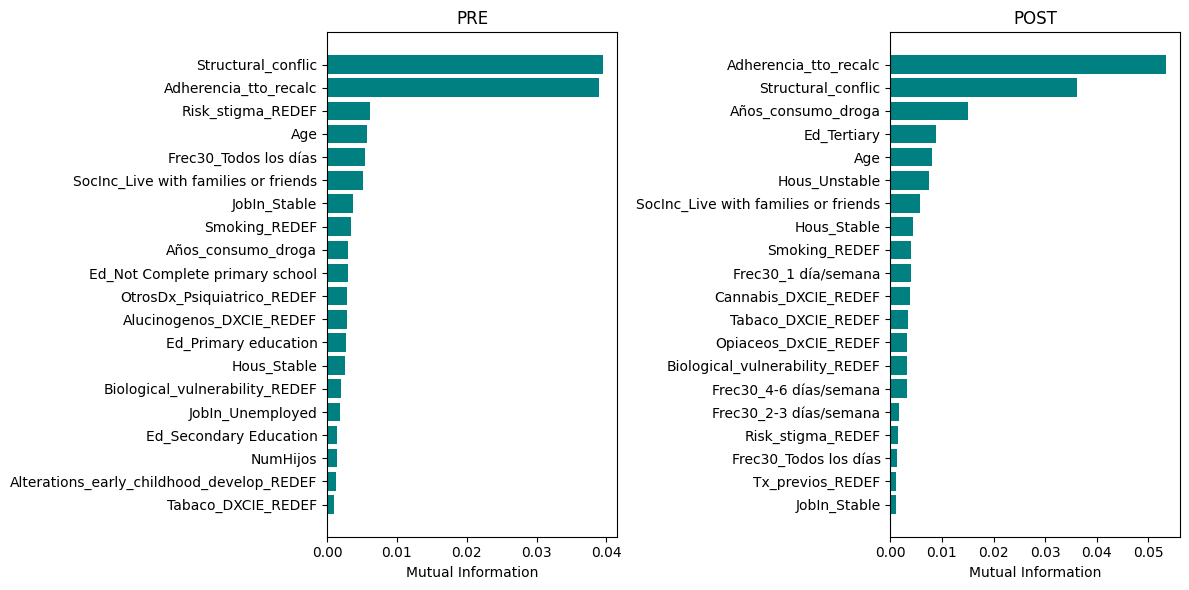

In [31]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PRE
importances_MI = mutual_info_classif(X_pre, y_pre, random_state = 42)
feat_importances_MI = pd.Series(importances_MI, feat)
feat_importances_MI.sort_values(inplace=True)
axes[0].barh(feat_importances_MI[feat_importances_MI != 0][-20:].index, feat_importances_MI[feat_importances_MI != 0][-20:], color='teal')
axes[0].set_xlabel("Mutual Information")
axes[0].set_title("PRE")

# POST
importances_MI = mutual_info_classif(X_post, y_post, random_state = 42)
feat_importances_MI = pd.Series(importances_MI, feat)
feat_importances_MI.sort_values(inplace=True)
axes[1].barh(feat_importances_MI[feat_importances_MI != 0][-20:].index, feat_importances_MI[feat_importances_MI != 0][-20:], color='teal')
axes[1].set_xlabel("Mutual Information")
axes[1].set_title("POST")

plt.tight_layout()
plt.savefig('EDA_plots/features/mutual_info.svg', format='svg', dpi=1200)
plt.show()


###### ANOVA

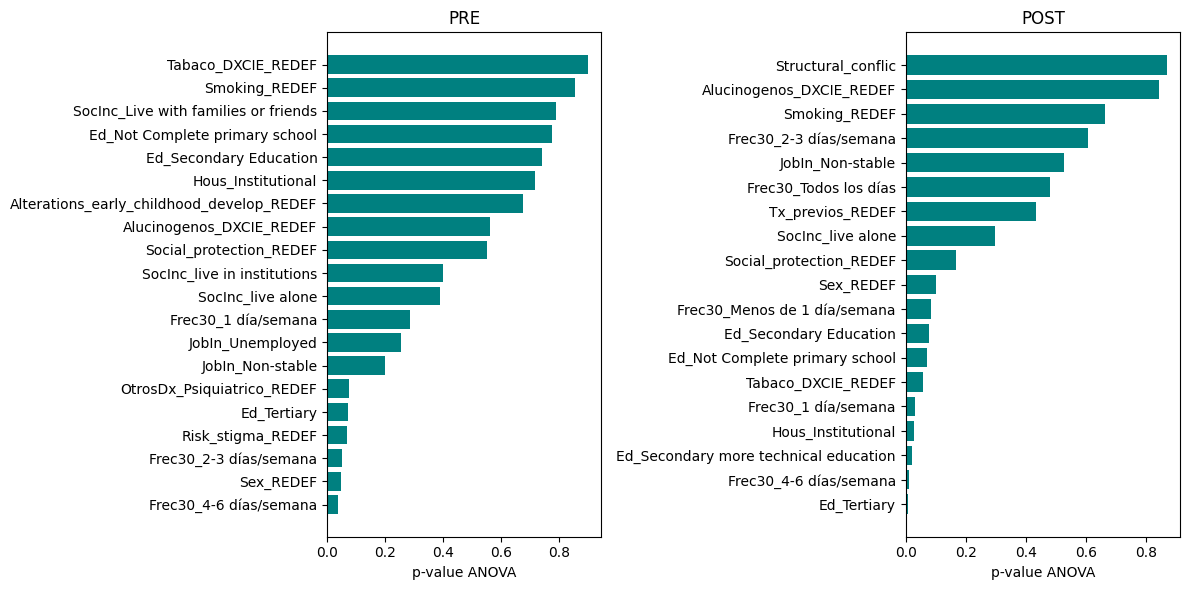

In [35]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PRE
selector = SelectKBest(f_classif, k=39)
selector.fit(X_pre, y_pre)
feat_importances_AN_pre = pd.Series(selector.pvalues_, feat)
feat_importances_AN_pre.sort_values(inplace=True)
axes[0].barh(feat_importances_AN_pre[feat_importances_AN_pre > 0.005][-20:].index, feat_importances_AN_pre[feat_importances_AN_pre > 0.005][-20:], color='teal')
axes[0].set_xlabel("p-value ANOVA")
axes[0].set_title("PRE")

# POST
selector = SelectKBest(f_classif, k=39)
selector.fit(X_post, y_post)
feat_importances_AN_post = pd.Series(selector.pvalues_, feat)  # Corrected variable name
feat_importances_AN_post.sort_values(inplace=True)
axes[1].barh(feat_importances_AN_post[feat_importances_AN_post > 0.005][-20:].index, feat_importances_AN_post[feat_importances_AN_post > 0.005][-20:], color='teal') 
axes[1].set_xlabel("p-value ANOVA")
axes[1].set_title("POST")

plt.tight_layout()
plt.savefig('EDA_plots/features/ANOVA.svg', format='svg', dpi=1200)
plt.show()